In [2]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import SimpleImputer
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from collections import Counter

In [3]:
class CategoryEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, min_cnt=5, word2idx=None, idx2word=None):
        super().__init__()
        self.min_cnt = min_cnt
        self.word2idx = word2idx if word2idx else dict()
        self.idx2word = idx2word if idx2word else dict()
    
    def fit(self, x, y=None):
        if not self.word2idx:
            counter = Counter(np.asarray(x).ravel())
            
            selected_terms = sorted(list(filter(lambda x:counter[x] >= self.min_cnt, counter)))
            
            self.word2idx = dict(zip(selected_terms, range(1, len(selected_terms) + 1)))
            self.word2idx['__PAD__'] = 0
            if '__UNKNOWN__' not in self.word2idx:
                self.word2idx['__UNKNOWN__'] = len(self.word2idx)
        if not self.idx2word:
            self.idx2word = {index:word for word, index in self.word2idx.items()}
        return self
    def transform(self, x):
        transformed_x = list()
        for term in np.asarray(x).ravel():
            try:
                transformed_x.append(self.word2idx[term])
            except KeyError:
                transformed_x.append(self.word2idx['__UNKNOWN__'])
        return np.asarray(transformed_x, dtype=np.float64)
    def dimension(self):
        return len(self.word2idx)

class SequenceEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, sep=' ', min_cnt=5, max_len=None, word2idx=None, idx2word=None):
        super().__init__()
        self.sep = sep
        self.min_cnt = min_cnt
        self.max_len = max_len
        
        self.word2idx = word2idx if word2idx else dict()
        self.idx2word = idx2word if idx2word else dict()
    def fit(self, x, y=None):
        if not self.word2idx:
            counter = Counter()
            max_len = 0
            for sequence in np.array(x).ravel():
                words = sequence.split(self.sep)
                counter.update(words)
                max_len = max(max_len, len(words))
            if self.max_len is None:
                self.max_len = max_len
            
            #drop rate words
            words = sorted(list(filter(lambda x:counter[x] >= self.min_cnt, counter)))
            
            self.word2idx = dict(zip(words, range(1, len(words)+1)))
            self.word2idx['__PAD__'] = 0
            if '__UNKNOWN__' not in self.word2idx:
                self.word2idx['__UNKNOWN__'] = len(self.word2idx)
        if not self.idx2word:
            self.idx2word = {index:word for word, index in self.word2idx.items()}
        
        if not self.max_len:
            max_len = 0
            for sequence in np.array(x).ravel():
                words = sequence.split(self.sep)
                max_len = max(max_len, len(words))
            self.max_len = max_len
        return self
    def transform(self, x):
        transformed_x = list()
        for sequence in np.asarray(x).ravel():
            words = list()
            for word in sequence.split(self.sep):
                try:
                    words.append(self.word2idx[word])
                except KeyError:
                    words.append(self.word2idx['__UNKNOWN__'])
            transformed_x.append(np.asarray(words[0:self.max_len], dtype=np.int64))
        return np.asarray(transformed_x, dtype=object)
    def dimension(self):
        return len(self.word2idx)
    def max_length(self):
        return self.max_len

In [4]:
dftrain = pd.read_csv('./train.csv')
dfval = pd.read_csv('./test.csv')

for col in ['movieId', 'histHighRatedMovieIds', 'negHistMovieIds', 'genres']:
    dftrain[col] = dftrain[col].astype(str)
    dfval[col] = dfval[col].astype(str)

num_features = ['age']
cat_features = ['gender', 'movieId', 'occupation', 'zipCode']
seq_features = ['genres', 'histHighRatedMovieIds', 'negHistMovieIds']

num_pipe = Pipeline(steps=[('impute',SimpleImputer()), ('quantile', QuantileTransformer())])

encoders = {}
print('preprocess number features...')
dftrain[num_features] = num_pipe.fit_transform(dftrain[num_features]).astype(np.float32)
dfval[num_features] = num_pipe.fit_transform(dfval[num_features]).astype(np.float32)

print('preprocess category features...')
for col in tqdm(cat_features):
    encoders[col] = CategoryEncoder(min_cnt=5)
    dftrain[col] = encoders[col].fit_transform(dftrain[col])
    dfval[col] = encoders[col].transform(dfval[col])
print('preprocess sequence features....')
for col in tqdm(seq_features):
    encoders[col] = SequenceEncoder(sep='|',min_cnt=5)
    dftrain[col] = encoders[col].fit_transform(dftrain[col])
    dfval[col] = encoders[col].transform(dfval[col])

 67%|██████▋   | 2/3 [00:00<00:00, 18.85it/s]

preprocess number features...
preprocess category features...
preprocess sequence features....


100%|██████████| 3/3 [00:00<00:00, 17.02it/s]


In [1]:
import torch

In [116]:
from collections import OrderedDict
from itertools import chain
from torch.utils.data import Dataset, DataLoader

class Df2Dataset(Dataset):
    def __init__(self, dfdata, num_features, cat_features, seq_features, encoders, label_col='label'):
        self.dfdata = dfdata
        self.num_features = num_features
        self.cat_features = cat_features
        self.seq_features = seq_features
        self.encoders = encoders
        self.label_col = label_col
        self.size = len(self.dfdata)
    def __len__(self):
        return self.size
    @staticmethod
    def pad_sequence(sequence, max_length):
        padded_seq = np.zeros(max_length, np.int32)
        padded_seq[0:sequence.shape[0]] = sequence
        return padded_seq
    def __getitem__(self, idx):
        record = OrderedDict()
        for col in self.num_features:
            record[col] = self.dfdata[col].iloc[idx].astype(np.float32)
        
        for col in self.cat_features:
            record[col] = self.dfdata[col].iloc[idx].astype(np.int64)
        
        for col in self.seq_features:
            seq = self.dfdata[col].iloc[idx]
            max_length = self.encoders[col].max_length()
            record[col] = Df2Dataset.pad_sequence(seq, max_length)
        if self.label_col is not None:
            record['label'] = self.dfdata[self.label_col].iloc[idx].astype(np.float32)
        return record
    def get_num_batches(self, batch_size):
        return np.ceil(self.size / batch_size)

ds_train = Df2Dataset(dftrain, num_features, cat_features, seq_features, encoders)
ds_val = Df2Dataset(dfval, num_features, cat_features, seq_features, encoders)
dl_train = DataLoader(ds_train, batch_size=128, shuffle=True)
df_val = DataLoader(ds_val,  batch_size=128, shuffle=False)

cat_nums = {k:v.dimension() for k,v in encoders.items()}

for batch in dl_train:
    print(batch['age'][0:2])
    print(batch['gender'][0:2])
    print(batch['genres'][0:2])
    print(batch['label'].shape)
    print(type(batch))
    print(batch.keys())
    break
print(cat_nums)

tensor([0.8964, 0.8078])
tensor([2, 2])
tensor([[5, 0, 0, 0, 0, 0],
        [6, 0, 0, 0, 0, 0]], dtype=torch.int32)
torch.Size([128])
<class 'dict'>
dict_keys(['age', 'gender', 'movieId', 'occupation', 'zipCode', 'genres', 'histHighRatedMovieIds', 'negHistMovieIds', 'label'])
{'gender': 4, 'movieId': 280, 'occupation': 23, 'zipCode': 124, 'genres': 20, 'histHighRatedMovieIds': 1791, 'negHistMovieIds': 3868}


In [104]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from collections import OrderedDict

class MaxPooling(nn.Module):
    def __init__(self, dim):
        super(MaxPooling, self).__init__()
        self.dim = dim
    def forward(self, x):
        return torch.max(x, self.dim)[0]
class SumPooling(nn.Module):
    def __init__(self, dim):
        super(SumPooling, slef).__init__()
        self.dim = dim
    def forward(self, x):
        return torch.sum(x, self.dim)
#同DIN，Dice激活函数
class Dice(nn.Module):
    def __init__(self, emb_size, dim=2, epsilon=1e-8):
        super(Dice, self).__init__()
        assert dim == 2 or dim == 3
        
        self.bn = nn.BatchNorm1d(emb_size, eps=epsilon)
        self.sigmoid = nn.Sigmoid()
        self.dim = dim
#          self.alpha = nn.Parameter(torch.zeros((emb_size,))) if self.dim == 2 else nn.Parameter(torch.zeros((emb_size, 1)))

        self.alpha = nn.Parameter(torch.zeros(emb_size)) if self.dim == 2 else nn.Parameter(torch.zeros(emb_size,1))
    def forward(self, x):
        assert x.dim() == self.dim
        if self.dim == 2:
            x_p = self.sigmoid(self.bn(x))
            out = self.alpha * (1 - x_p) * x + x_p * x
        else:
            x = torch.transpose(x, 1, 2)
            x_p = self.sigmoid(self.bn(x))
            out = self.alpha * (1 - x_p) * x + x_p * x
            out = torch.transpose(out, 1, 2)
        return out
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x
def get_activation_layer(name, hidden_size=None, dice_dim=2):
    name = name.lower()
    name_dict = {x.lower():x for x in dir(nn) if '__' not in x and 'Z'>=x[0]>='A'}
    if name=='linear':
        return Identity()
    elif name == 'dice':
        assert dice_dim
        return Dice(hidden_size, dice_dim)
    else:
        assert name in name_dict, f'activation type {name} not supported!'
        return getattr(nn, name_dict[name])()
def init_weights(model):
    if isinstance(model, nn.Linear):
        if model.weight is not None:
            nn.init.kaiming_uniform_(model.weight.data)
        if model.bias is not None:
            nn.init.normal_(model.bias.data)
    elif isinstance(model, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
        if model.weight is not None:
            nn.init.normal_(model.weight.data, mean=1, std=0.02)
        if model.bias is not None:
            nn.init.constant_(model.bias.data, 0)
    else:
        pass
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout=0.0, batchnorm=True, activation='relu'):
        super(MLP, self).__init__()
        modules = OrderedDict()
        previous_size = input_size
        for index, hidden_layer in enumerate(hidden_layers):
            modules[f"dense{index}"] = nn.Linear(previous_size, hidden_layer)
            if batchnorm:
                modules[f"batchnorm{index}"] = nn.BatchNorm1d(hidden_layer)
            if activation:
                modules[f"activation{index}"] = get_activation_layer(activation, hidden_layer, 2)
            if dropout:
                modules[f"dropout{index}"] = nn.Dropout(dropout)
            previous_size = hidden_layer
        self.mlp = nn.Sequential(modules)
    def forward(self, x):
        return self.mlp(x)
class AttentionGRUCell(nn.Module):
    #AGRU的实现
    def __init__(self, input_size, hidden_size, bias=True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        #Wn就是公式中的Wh
        #(Wr|Wn)
        self.weight_ih = nn.Parameter(torch.Tensor(2 * hidden_size, input_size))
        #Un就是公式中的Uh
        #(Ur|Un)
        self.weight_hh = nn.Parameter(torch.Tensor(2 * hidden_size, input_size))
        if bias:
            #(b_ir|b_in)
            self.bias_ih = nn.Parameter(torch.Tensor(2 * hidden_size))
            #(b_hr|b_hn)
            self.bias_hh = nn.Parameter(torch.Tensor(2 * hidden_size))
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)
        self.reset_parameters()
    def reset_parameters(self):
        stdv = 1.0 / (self.hidden_size) ** 0.5
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)
    def forward(self, x, hx, att_score):
        gi = F.linear(x, self.weight_ih, self.bias_ih)
        gh = F.linear(hx, self.weight_hh, self.bias_hh)
        i_r, i_n = gi.chunk(2,1) #i_r，rt公式中it那项的结果加上偏置项结果，i_n是ht波浪线第一项结果
        h_r, h_n = gh.chunk(2,1)#h_r,rt那项h(t-1)那项的结果加上偏置项结果, h_n是ht波浪线第二项rt后面的结果
        
        resetgate = torch.sigmoid(i_r + h_r) #重置门，
        newgate = torch.tanh(i_n + resetgate * h_n)  #ht波浪线结果
        att_score = att_score.view(-1,1)
        hy = (1. - att_score) * hx + att_score * newgate #attention score替换了更新门，直接作用于隐藏状态
        return hy
class AttentionUpdateGateGRUCell(nn.Module):
    #AUGRU的实现
    def __init__(self, input_size, hidden_size, bias=True):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        #(Wu|Wr|Wn) Wn就是公式中的Wh
        self.weight_ih = nn.Parameter(torch.Tensor(3 * hidden_size, input_size))
        #(Uu|Ur|Un)  Un就是公式中的Uh
        self.weight_hh = nn.Parameter(torch.Tensor(3 * hidden_size, hidden_size))
        if bias:
            #(b_iu|b_ir|b_in)
            self.bias_ih = nn.Parameter(torch.Tensor(3 * hidden_size))
            #(b_hu|b_hr|b_hn)
            self.bias_hh = nn.Parameter(torch.Tensor(3 * hidden_size))
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)
        self.reset_parameters()
    def reset_parameters(self):
        stdv = 1.0 / (self.hidden_size) ** 0.5
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)
    def forward(self, x, hx, att_score):
        gi = F.linear(x, self.weight_ih, self.bias_ih)
        gh = F.linear(hx, self.weight_hh, self.bias_hh)
        i_u, i_r, i_n = gi.chunk(3,1) #i_u更新门中的第一项，i_r重置门中的第一项,i_n是当前状态信息计算中的第一项
        h_u, h_r, h_n = gi.chunk(3,1)#h_u更新们中第二项，h_r重置门中的第二项，h_n是当前状态信息计算中的第二项rt后的项
        
        updategate = torch.sigmoid(i_u + h_u)  #更新门
        resetgate = torch.sigmoid(i_r + h_r)  #重置门
        newgate = torch.tanh(i_n + resetgate * h_n)#当前状态信息计算
        
        updategate = att_score.view(-1,1) * updategate  #attention score作用于更新门
        hy = (1 - updategate)*hx + updategate*newgate
        return hy
#兴趣演化层
class DynamicGRU(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, gru_type='AGRU'):
        super(DynamicGRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        if gru_type == 'AGRU':
            self.rnn = AttentionGRUCell(input_size, hidden_size, bias)
        elif gru_type == 'AUGRU':
            self.rnn = AttentionUpdateGateGRUCell(input_size, hidden_size, bias)
    def forward(self, x, att_scores, hx=None):
        is_packed_input = isinstance(x, nn.utils.rnn.PackedSequence)
        if not is_packed_input:
            raise NotImplementedError('DynamicGRU only supports packed input')
        is_packed_att_scores = isinstance(att_scores, nn.utils.rnn.PackedSequence)
        if not is_packed_att_scores:
            raise NotImplementedError('DynamicGRU only packed att_scores')
        x, batch_sizes, sorted_indices, unsorted_indices = x
        att_scores, _,_,_= att_scores
        
        max_batch_size = batch_sizes[0]
        max_batch_size = int(max_batch_size)
        
        if hx is None:
            hx = torch.zeros(max_batch_size, self.hidden_size, dtype=x.dtype, device=x.device)
        outputs = torch.zeros(x.size(0), self.hidden_size, dtype=x.dtype, device=x.device)
        
        begin = 0
        for batch in batch_sizes:
            new_hx = self.rnn(x[begin:begin+batch], hx[0:batch], att_scores[begin:begin+batch])
            outputs[begin:begin+batch] = new_hx
            hx = new_hx
            begin += batch
        return nn.utils.rnn.PackedSequence(outputs, batch_sizes, sorted_indices, unsorted_indices)
#注意力层，用一个mlp网络来得到了每个兴趣抽取输出与目标的关系
class Attention(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout=0.0, batchnorm=True, activation='prelu', return_scores=False):
        super().__init__()
        self.return_scores = return_scores
        
        self.mlp = MLP(input_size=input_size * 4, hidden_layers=hidden_layers, dropout=dropout, batchnorm=batchnorm, activation=activation)
#         print("attention self.mlp")
#         print(self.mlp)
        self.fc = nn.Linear(hidden_layers[-1], 1)
    def forward(self, query, keys, keys_length):
        """
        Parameters
        ------------
        query:2D tensor,[Batch,Hidden]
        keys:3D tensor, [Batch, Time, Hidden]
        keys_length:1D tensor,[Batch]
        Returns
        ------
        outputs:2D tensor,[Batch, Hidden]
        """
        batch_size, max_length, dim = keys.size()
        query = query.unsqueeze(1).expand(-1, max_length, -1)
        din_all = torch.cat([query, keys, query-keys, query*keys], dim=-1)
        din_all = din_all.view(batch_size * max_length, -1)
#         print('din_all:', din_all.shape)
        outputs = self.mlp(din_all)
        outputs = self.fc(outputs).view(batch_size, max_length) #[B, T]
        
        #scale
        outputs = outputs / (dim ** 0.5)
        #Mask
        mask = (torch.arange(max_length, device=keys_length.device).repeat(batch_size, 1)<keys_length.view(-1,1))
        outputs[~mask] = -np.inf
        #Activation
        outputs = F.softmax(outputs, dim=1) #din uses sigmod,dien uses softmax,[B,T]
        
        if not self.return_scores:
            #weighted sum
            outputs = torch.matmul(outputs.unsqueeze(1), keys).squeeze() #[B,H]

        return outputs
#用来得到兴趣抽取层每步隐藏状态的辅助网络
class AuxiliaryNet(nn.Module):
    def __init__(self, input_size, hidden_layers, activation='sigmoid'):
        super().__init__()
        modules = OrderedDict()
        previous_size = input_size
        for index, hidden_layer in enumerate(hidden_layers):
            modules[f"dense{index}"] = nn.Linear(previous_size, hidden_layer)
            if activation:
                modules[f"activation{index}"] = get_activation_layer(activation)
            previous_size = hidden_layer
        modules['final_layer'] = nn.Linear(previous_size, 1)
        self.mlp = nn.Sequential(modules)
    def forward(self, x):
        return torch.sigmoid(self.mlp(x))
#兴趣提取层，该层调用了兴趣演化层的gru得到了最终的用户演化兴趣
class Interest(nn.Module):
    SUPPORTED_GRU_TYPE = ['GRU', 'AIGRU', 'AGRU', 'AUGRU']
    
    def __init__(self, input_size, gru_type='AUGRU', gru_dropout=0.0, att_hidden_layers=[80,40], att_dropout=0.0, att_batchnorm=True, 
                att_activation='prelu', use_negsampling=False):
        super(Interest, self).__init__()
        if gru_type not in Interest.SUPPORTED_GRU_TYPE:
            raise NotImplementedError(f"gru_type:{gru_type} is not supported")
        self.gru_type = gru_type
        self.use_negsampling = use_negsampling
        self.interest_extractor = nn.GRU(input_size=input_size, hidden_size=input_size, batch_first=True, bidirectional=False)
        
        if self.use_negsampling:
            self.auxiliary_net = AuxiliaryNet(input_size * 2, hidden_layers=[100,50])
        if gru_type == 'GRU':
            self.attention = Attention(input_size=input_size, hidden_layers=att_hidden_layers, dropout=att_dropout,
                                      batchnorm=att_batchnorm, activation=att_activation)
            self.interest_evolution = nn.GRU(input_size=input_size, hidden_size=input_size, batch_first=True, bidirectional=False)
        elif gru_type == 'AIGRU':
            self.attention = Attention(input_size=input_size, hidden_layers=att_hidden_layers, dropout=att_dropout, batchnorm=att_batchnorm,
                                      activation=att_activation,return_scores=True)
            self.interest_evolution = nn.GRU(inputt_size=input_size, hidden_size=input_size, batch_first=True, bidirectional=False)
        elif gru_type == 'AGRU' or gru_type == 'AUGRU':
            self.attention = Attention(input_size=input_size, hidden_layers=att_hidden_layers, dropout=att_dropout, batchnorm=att_batchnorm,
                                      activation=att_activation, return_scores=True)
            self.interest_evolution = DynamicGRU(input_size=input_size, hidden_size=input_size, gru_type=gru_type)
    @staticmethod
    def get_last_state(states, keys_length):
        #states[B,T,H]
        batch_size, max_seq_length, hidden_size = states.size()
        mask = (torch.arange(max_seq_length, device=keys_length.device).repeat(batch_size,1)==(keys_length.view(-1,1)-1))
        return states[mask]
    def cal_auxiliary_loss(self, states, click_seq, noclick_seq, keys_length):
        #states [B,T,H],兴趣提取层隐藏状态的输出
        #click_seq [B,T,H]，下一个时刻用户点击的embedding向量
        #noclick_seq [B,T,H] ，下一个时刻用户未点击的embedding向量
        #keys_length [B]   用户历史行为序列的长度，注意这里是原序列长度-1，因为最后一个时间步的输出就没法计算了
        batch_size, max_seq_length, embedding_size = states.size()
        mask = (torch.arange(max_seq_length, device=states.device).repeat(batch_size,1) < keys_length.view(-1,1)).float()
        click_input = torch.cat([states, click_seq], dim=-1)
        noclick_input = torch.cat([states,noclick_seq], dim=-1)
        embedding_size = embedding_size * 2
        click_p = self.auxiliary_net(click_input.view(batch_size * max_seq_length, embedding_size)).view(batch_size, max_seq_length)[mask > 0].view(-1,1)
        click_target = torch.ones(click_p.size(), dtype=torch.float, device=click_p.device)
        noclick_p = self.auxiliary_net(noclick_input.view(batch_size * max_seq_length, embedding_size)).view(batch_size, max_seq_length)[mask>0].view(-1,1)
        noclick_target = torch.zeros(noclick_p.size(), dtype=torch.float, device=noclick_p.device)
        
        loss = F.binary_cross_entropy(torch.cat([click_p, noclick_p],dim=0),
                                     torch.cat([click_target, noclick_target], dim=0))
        return loss
    def forward(self, query, keys, keys_length, neg_keys=None):
        """
        Parameters
        ------------
        query:2D tensor,[Batch, Hidden]
        keys:3D tensor,[Batch, Time, Hidden]
        keys_length:1D tensor,[Batch]
        neg_keys:3D tensor,[Batch,Time, Hidden]
        
        returns
        outputs:2D tensor, [Batch, Hidden]
        """
        batch_size, max_length, dim = keys.size()
        packed_keys = pack_padded_sequence(keys, lengths=keys_length.squeeze().cpu(), batch_first=True, enforce_sorted=False)
        packed_interests, _ = self.interest_extractor(packed_keys)
        aloss = None
        if (self.gru_type != 'GRU') or self.use_negsampling:
            interests, _ = pad_packed_sequence(packed_interests, batch_first=True, padding_value=0.0, total_length=max_length)
            if self.use_negsampling:
                aloss = self.cal_auxiliary_loss(interests[:,:-1,:], keys[:,1:,:], neg_keys[:,1:,:], keys_length-1)
#                 print('aloss:', aloss)
        if self.gru_type == 'GRU':
            packed_interests, _ = self.interest_evolution(packed_interests)
            interests, _ = pad_packed_sequence(packed_interests, batch_first=True, padding_value=0.0, total_length=max_length)
            outputs = self.attention(query, interests, keys_length)
        elif self.gru_type == 'AIGRU':
            #attention，直接在兴趣提取层的输出向量上乘以注意力得分
            scores = self.attention(query, interests, keys_length)
            interests = interests * scores.unsqueeze(-1)
            
            packed_interests = pack_padded_sequence(interests, lengths=keys_length.squeeze().cpu(), batch_first=True, enforce_sorted=False)
            _, outputs = self.interest_evolution(packed_interests)
            outputs = outputs.squeeze()
        elif self.gru_type == 'AGRU' or self.gru_type == 'AUGRU':
            #attention,得到注意力得分
            scores = self.attention(query, interests, keys_length)
#             print('scores:', scores)
            packed_interests = pack_padded_sequence(interests, lengths=keys_length.squeeze().cpu(), batch_first=True, enforce_sorted=False)
            packed_scores = pack_padded_sequence(scores, lengths=keys_length.squeeze().cpu(), batch_first=True, enforce_sorted=False)
            outputs, _ = pad_packed_sequence(self.interest_evolution(packed_interests, packed_scores), batch_first=True)
            #pick last state
            outputs = Interest.get_last_state(outputs, keys_length.squeeze())
            
        return outputs, aloss
class AttentionGroup(object):
    def __init__(self, name, pairs, hidden_layers, activation='dice', att_dropout=0.0, gru_type='AUGRU', gru_dropout=0.0):
        self.name = name
        self.pairs = pairs
        self.hidden_layers = hidden_layers
        self.activation = activation
        self.att_dropout = att_dropout
        self.gru_type = gru_type
        self.gru_dropout = gru_dropout
        
        self.related_feature_names = set()
        self.neg_feature_names = set()
        for pair in pairs:
            self.related_feature_names.add(pair['ad'])
            self.related_feature_names.add(pair['pos_hist'])
            if 'neg_hist' in pair:
                self.related_feature_names.add(pair['neg_hist'])
                self.neg_feature_names.add(pair['neg_hist'])
    def is_attention_feature(self, feature_name):
        if feature_name in self.related_feature_names:
            return True
        return False
    def is_neg_sampling_feature(self, feature_name):
        if feature_name in self.neg_feature_names:
            return True
        return False
    @property
    def pairs_count(self):
        return len(self.pairs)
class DIEN(nn.Module):
    def __init__(self, num_features, cat_features, seq_features, cat_nums, embedding_size, attention_groups, mlp_hidden_layers, mlp_activation='prelu',
                mlp_dropout=0.0, use_negsampling=False, d_out=1):
        super().__init__()
        self.num_features = num_features
        self.cat_features = cat_features
        self.seq_features = seq_features
        self.cat_nums = cat_nums
        self.embedding_size = embedding_size
        self.attention_groups = attention_groups
        self.mlp_hidden_layers = mlp_hidden_layers
        self.mlp_activation = mlp_activation
        self.mlp_dropout = mlp_dropout
        
        self.d_out = d_out
        self.use_negsampling = use_negsampling
        #embedding
        self.embeddings = OrderedDict()
        #对于普通类别特征和序列特征都做embedding
        for feature in self.cat_features + self.seq_features:
            self.embeddings[feature] = nn.Embedding(self.cat_nums[feature], self.embedding_size, padding_idx=0)
            self.add_module(f"embedding:{feature}", self.embeddings[feature])
        self.sequence_poolings = OrderedDict()
        self.attention_poolings = OrderedDict()
        total_embedding_sizes = 0
        for feature in self.cat_features:
            total_embedding_sizes += self.embedding_size
        for feature in self.seq_features:
            if not self.is_neg_sampling_feature(feature):
                total_embedding_sizes += self.embedding_size
        
        #sequence_pooling
        for feature in self.seq_features:
            if not self.is_attention_feature(feature):
                self.sequence_poolings[feature] = MaxPooling(1)
                self.add_module(f"pooling:{feature}", self.sequence_poolings[feature])
        #attention_pooling
        for attention_group in self.attention_groups:
            self.attention_poolings[attention_group.name] = self.create_attention_fn(attention_group)
            self.add_module(f"attention_pooling:{attention_group.name}", self.attention_poolings[attention_group.name])
        total_input_size = total_embedding_sizes + len(self.num_features)
        
        self.mlp = MLP(total_input_size, mlp_hidden_layers, dropout=mlp_dropout, batchnorm=True, activation=mlp_activation)
        self.final_layer = nn.Linear(mlp_hidden_layers[-1], self.d_out)
        self.apply(init_weights)
    def forward(self, x):
        final_layer_inputs = list()
        #linear
        number_inputs = list()
        for feature in self.num_features:
            number_inputs.append(x[feature].view(-1,1))
        
        embeddings = OrderedDict()
        #对普通类别特征做embedding
        for feature in self.cat_features:
            embeddings[feature] = self.embeddings[feature](x[feature].long())
        #如果序列特征不做注意力，那就用sequence_pooling
        for feature in self.seq_features:
            if not self.is_attention_feature(feature):
                embeddings[feature] = self.sequence_poolings[feature](self.embeddings[feature](x[feature].long()))
        auxiliary_losses = []
        for attention_group in self.attention_groups:
            query = torch.cat([embeddings[pair['ad']] for pair in attention_group.pairs], dim=-1)
            pos_hist = torch.cat([self.embeddings[pair['pos_hist']](x[pair['pos_hist']].long()) for pair in attention_group.pairs], dim=-1)

            keys_length = torch.min(torch.cat([torch.sum(x[pair['pos_hist']]>0,dim=1).view(-1,1) for pair in attention_group.pairs],dim=-1), dim=-1)[0]
            neg_hist = None
            if self.use_negsampling:
                neg_hist = torch.cat([self.embeddings[pair['neg_hist']](x[pair['neg_hist']].long()) for pair in attention_group.pairs], dim=-1)
            embeddings[attention_group.name], tmp_loss = self.attention_poolings[attention_group.name](query, pos_hist, keys_length, neg_hist)
            if tmp_loss is not None:
                auxiliary_losses.append(tmp_loss)
        emb_concat = torch.cat(number_inputs + [emb for emb in embeddings.values()], dim=-1)
#         print('emb_concat:', emb_concat.shape)
        final_layer_inputs = self.mlp(emb_concat)
        output = self.final_layer(final_layer_inputs)
        
        auxiliary_avg_loss = None
        if auxiliary_losses:
            auxiliary_avg_loss = auxiliary_losses[0]
            size = len(auxiliary_losses)
            for i in range(1, size):
                auxiliary_avg_loss += auxiliary_losses[i]
            auxiliary_avg_loss /= size
        if self.d_out == 1:
            output = output.squeeze()
            output = torch.sigmoid(output)
        return output, auxiliary_avg_loss
    def create_attention_fn(self, attention_group):
        return Interest(attention_group.pairs_count * self.embedding_size, gru_type=attention_group.gru_type,
                       gru_dropout= attention_group.gru_dropout, att_hidden_layers=attention_group.hidden_layers,
                       att_dropout=attention_group.att_dropout,att_activation=attention_group.activation,
                       use_negsampling=self.use_negsampling)
    def is_attention_feature(self, feature):
        for group in self.attention_groups:
            if group.is_attention_feature(feature):
                return True
        return False
    def is_neg_sampling_feature(self, feature):
        for group in self.attention_groups:
            if group.is_neg_sampling_feature(feature):
                return True
        return False
    

In [105]:
def create_net():
    augru_attention_groups_with_neg = [
    AttentionGroup(
        name='group1',
        pairs=[{'ad': 'movieId', 'pos_hist': 'histHighRatedMovieIds', 'neg_hist': 'negHistMovieIds'}],
        hidden_layers=[16, 8], att_dropout=0.1, gru_type='AUGRU')
    ]
 
    net = DIEN(num_features=num_features,
           cat_features=cat_features,
           seq_features=seq_features,
           cat_nums = cat_nums,
           embedding_size=16,
           attention_groups=augru_attention_groups_with_neg,
           mlp_hidden_layers=[32,16],
           mlp_activation="prelu",
           mlp_dropout=0.25,
           use_negsampling=True,
           d_out=1
           )
    
    return net 
 
net = create_net() 
net
 


DIEN(
  (embedding:gender): Embedding(4, 16, padding_idx=0)
  (embedding:movieId): Embedding(280, 16, padding_idx=0)
  (embedding:occupation): Embedding(23, 16, padding_idx=0)
  (embedding:zipCode): Embedding(124, 16, padding_idx=0)
  (embedding:genres): Embedding(20, 16, padding_idx=0)
  (embedding:histHighRatedMovieIds): Embedding(1791, 16, padding_idx=0)
  (embedding:negHistMovieIds): Embedding(3868, 16, padding_idx=0)
  (pooling:genres): MaxPooling()
  (attention_pooling:group1): Interest(
    (interest_extractor): GRU(16, 16, batch_first=True)
    (auxiliary_net): AuxiliaryNet(
      (mlp): Sequential(
        (dense0): Linear(in_features=32, out_features=100, bias=True)
        (activation0): Sigmoid()
        (dense1): Linear(in_features=100, out_features=50, bias=True)
        (activation1): Sigmoid()
        (final_layer): Linear(in_features=50, out_features=1, bias=True)
      )
    )
    (attention): Attention(
      (mlp): MLP(
        (mlp): Sequential(
          (dense0):

In [106]:
out,aloss = net.forward(batch)
print(out)
print(out.shape)
print(aloss)

tensor([0.8949, 0.8928, 0.9280, 0.4070, 0.9930, 0.9201, 0.8962, 0.9338, 0.9414,
        0.7865, 0.9624, 0.6806, 0.7249, 0.8036, 0.9842, 0.8924, 0.9777, 0.8608,
        0.7367, 0.9364, 0.9596, 0.8733, 0.5051, 0.9635, 0.9704, 0.8239, 0.9314,
        0.9130, 0.5094, 0.9463, 0.9574, 0.9567, 0.7361, 0.9387, 0.8886, 0.9779,
        0.7662, 0.9182, 0.5474, 0.8799, 0.4164, 0.7268, 0.9168, 0.7534, 0.9164,
        0.6439, 0.9880, 0.9688, 0.8415, 0.9474, 0.9217, 0.9093, 0.8461, 0.8523,
        0.7598, 0.7161, 0.8888, 0.9086, 0.9788, 0.9656, 0.8674, 0.9881, 0.3559,
        0.9080, 0.8879, 0.9797, 0.8703, 0.8856, 0.9551, 0.8666, 0.6848, 0.4805,
        0.8486, 0.6566, 0.9640, 0.9680, 0.9112, 0.5340, 0.8245, 0.9276, 0.5719,
        0.7532, 0.9154, 0.9146, 0.2682, 0.4799, 0.9410, 0.8417, 0.9239, 0.9349,
        0.9812, 0.9834, 0.8919, 0.9012, 0.8113, 0.9555, 0.8512, 0.6907, 0.7667,
        0.8759, 0.1544, 0.8564, 0.8684, 0.9537, 0.8318, 0.8043, 0.9726, 0.5908,
        0.6833, 0.7921, 0.7578, 0.9559, 

In [107]:
import torch.optim as optim

def auc(y_pred, y_true):
    pred = y_pred.data
    y = y_true.data
    return roc_auc_score(y, pred)

loss_func = nn.BCELoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.001)
metric_func = auc
metric_name = 'auc'

In [109]:
epochs = 8
log_step_freq = 10

dfhistory = pd.DataFrame(columns=['epoch', 'loss', metric_name, 'val_loss', 'val_'+metric_name])

print('start_training.........')
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('========'*8 + '%s' %nowtime)

for epoch in range(1, epochs+1):
    
    # 训练阶段
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, batch in enumerate(dl_train, 1):
        # 梯度清零
        optimizer.zero_grad()
        
        # 正向传播
        predictions, aloss = net(batch)
        labels = batch['label']
        loss = loss_func(predictions, labels) + aloss
        try:
            metric = metric_func(predictions, labels)
        except ValueError:
            pass
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(("[step=%d] loss: %.3f, " + metric_name + ": %.3f") % (step, loss_sum/step, metric_sum/step));
    
    # 验证阶段
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    
    for val_step, batch in enumerate(df_val, 1):
        with torch.no_grad():
            predictions, aloss = net(batch)
            labels = batch['label']
            val_loss = loss_func(predictions, labels) + aloss
            try:
                val_metric = metric_func(predictions, labels)
            except ValueError:
                pass
        
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
    
    # 记录日志
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印日志
    print(("\nEPOCH=%d, loss=%.3f, " + metric_name + " = %.3f, val_loss=%.3f, " + "val_" + metric_name + " = %.3f") %info)
    nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print('\n' + '=========='* 8 + '%s' %nowtime)
    
print('Finished Training')

start_training.........
================================================================2022-08-17 11:00:40
[step=10] loss: 1.556, auc: 0.553
[step=20] loss: 1.544, auc: 0.556
[step=30] loss: 1.522, auc: 0.562

EPOCH=1, loss=1.506, auc = 0.569, val_loss=1.435, val_auc = 0.590

================================================================================2022-08-17 11:00:44
[step=10] loss: 1.463, auc: 0.582
[step=20] loss: 1.456, auc: 0.571
[step=30] loss: 1.440, auc: 0.580

EPOCH=2, loss=1.439, auc = 0.576, val_loss=1.379, val_auc = 0.596

================================================================================2022-08-17 11:00:47
[step=10] loss: 1.439, auc: 0.532
[step=20] loss: 1.415, auc: 0.567
[step=30] loss: 1.400, auc: 0.574

EPOCH=3, loss=1.399, auc = 0.569, val_loss=1.326, val_auc = 0.601

================================================================================2022-08-17 11:00:50
[step=10] loss: 1.333, auc: 0.607
[step=20] loss: 1.333, auc: 0.594
[step=30] loss

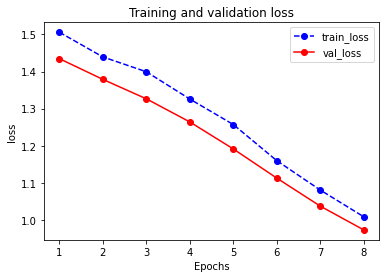

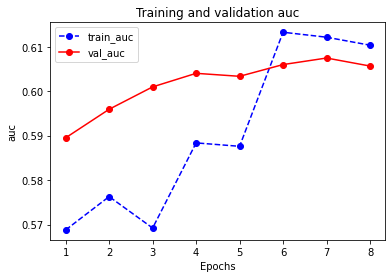

In [110]:
import matplotlib.pyplot as plt
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


# 观察损失和准确率的变化
plot_metric(dfhistory,"loss")
plot_metric(dfhistory,"auc")

In [146]:
# 预测
from sklearn.metrics import accuracy_score
labels = dfval['label'].values
y_pred_probs = torch.cat([net(x)[0] for x in df_val]) 
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))
val_auc = auc(y_pred_probs.data.numpy(),labels)
val_acc = accuracy_score(labels, y_pred.data.numpy())
print('val_auc:%.3f, val_acc:%.3f' % (val_auc, val_acc))


val_auc:0.611, val_acc:0.612
